In [2]:
import torch
import numpy as np
import pandas as pd
import os
from skimage import io
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset
# convert data to torch.FloatTensor
transform =transforms.Compose([transforms.ToPILImage(),transforms.CenterCrop(100),transforms.ToTensor()]) 

In [3]:
class LoadDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
       
        landmarks = self.landmarks_frame.iloc[idx, 1:].values
        y = np.asarray([float(landmarks[0]),float(landmarks[1]),float(landmarks[2]),float(landmarks[3])])
        if self.transform:
            image = self.transform(image)
#            print(idx,"   ",y)
            y = torch.from_numpy(y).type(torch.FloatTensor)
        return [image,y]
data = LoadDataset("autoencode_flipkart.csv","/media/dhruv/Games/flipkart_round3/training")

In [4]:
batch_size=28
num_workers = 1

trainloader = torch.utils.data.DataLoader(data,num_workers=num_workers,batch_size=batch_size,shuffle=True)


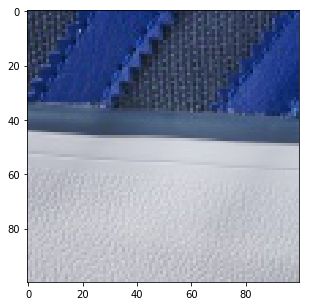

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])
fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img.transpose((1,2,0)))

In [6]:
img.shape

(3, 100, 100)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        self.enc = nn.Linear(30000,encoding_dim)
        ## decoder ##
        self.dec = nn.Linear(encoding_dim,30000)

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        x = F.sigmoid(self.dec(self.enc(x)))
        return x

# initialize the NN
encoding_dim = 1000
model = Autoencoder(encoding_dim).cuda()
print(model)

Autoencoder(
  (enc): Linear(in_features=30000, out_features=1000, bias=True)
  (dec): Linear(in_features=1000, out_features=30000, bias=True)
)


In [8]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [9]:
# number of epochs to train the model
n_epochs = 50

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in trainloader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images.cuda())
        # calculate the loss
        loss = criterion(outputs.cuda(), images.cuda())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(trainloader)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

/home/dhruv/anaconda3/envs/torch/lib/python3.7/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 1.787170
Epoch: 2 	Training Loss: 1.673335
Epoch: 3 	Training Loss: 1.710764
Epoch: 4 	Training Loss: 1.625691
Epoch: 5 	Training Loss: 1.575878
Epoch: 6 	Training Loss: 1.591056
Epoch: 7 	Training Loss: 1.576213
Epoch: 8 	Training Loss: 1.539933
Epoch: 9 	Training Loss: 1.511799
Epoch: 10 	Training Loss: 1.499711
Epoch: 11 	Training Loss: 1.482496
Epoch: 12 	Training Loss: 1.452369
Epoch: 13 	Training Loss: 1.420024
Epoch: 14 	Training Loss: 1.380772
Epoch: 15 	Training Loss: 1.332677
Epoch: 16 	Training Loss: 1.290228
Epoch: 17 	Training Loss: 1.242931
Epoch: 18 	Training Loss: 1.198380
Epoch: 19 	Training Loss: 1.182737
Epoch: 20 	Training Loss: 1.158705
Epoch: 21 	Training Loss: 1.059951
Epoch: 22 	Training Loss: 1.131402
Epoch: 23 	Training Loss: 1.066434
Epoch: 24 	Training Loss: 1.024362
Epoch: 25 	Training Loss: 0.977615
Epoch: 26 	Training Loss: 0.980268
Epoch: 27 	Training Loss: 0.908215
Epoch: 28 	Training Loss: 0.931125
Epoch: 29 	Training Loss: 0.9

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7f903ae40f28>
Traceback (most recent call last):
  File "/home/dhruv/anaconda3/envs/torch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dhruv/anaconda3/envs/torch/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dhruv/anaconda3/envs/torch/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dhruv/anaconda3/envs/torch/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dhruv/anaconda3/envs/torch/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dhruv/anaconda3/envs/torch/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return 

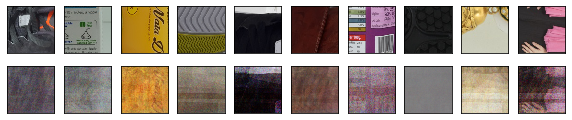

In [29]:
# obtain one batch of test images
dataiter = iter(trainloader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten.cuda())
# prep images for display
images = images.numpy()

# output is resized into a batch of images

output = output.view(batch_size, 3,100,100)
# use detach when it's an output that requires_grad
output = output.cpu().detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(10,2))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img.transpose((1,2,0))))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

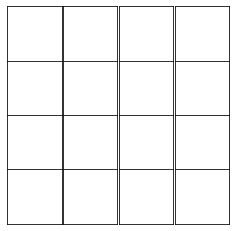

In [36]:
# import matplotlib.gridspec as gridspec
# plt.figure(figsize = (4,4))
# gs1 = gridspec.GridSpec(4, 4)
# gs1.update(wspace=0.0, hspace=0.0) # set the spacing between axes. 

# for i in range(16):
#    # i = i + 1 # grid spec indexes from 0
#     ax1 = plt.subplot(gs1[i])
#     plt.axis('on')
#     ax1.set_xticklabels([])
#     ax1.set_yticklabels([])
#     ax1.set_aspect('equal')
#     ax1.get_xaxis().set_visible(False)
#     ax1.get_yaxis().set_visible(False)

# plt.show()